In [1]:
!pwd

/content


In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:22
🔁 Restarting kernel...


Установка необходимых пакетов

In [ ]:
!conda install -c bioconda samtools

In [ ]:
! conda install -y -c bioconda hisat2

In [3]:
!ls drive/MyDrive/ngs_rna-seq_data

B14.5.fq.gz  B17.5.fq.gz  B34.fq.gz    C15.5.fq.gz  C20.fq.gz
B15.5.fq.gz  B20.fq.gz	  C14.5.fq.gz  C17.5.fq.gz  C34.fq.gz


Скачивание файлов с Ensembl

In [ ]:
!wget http://ftp.ensembl.org/pub/release-107/fasta/mus_musculus/dna/Mus_musculus.GRCm39.dna.chromosome.19.fa.gz
#19 chromosome sequence

In [ ]:
!wget http://ftp.ensembl.org/pub/release-107/gtf/mus_musculus/Mus_musculus.GRCm39.107.chr.gtf.gz
#annotation file

In [6]:
!mkdir genome-annotation
!mv Mus_musculus.GRCm39.107.chr.gtf.gz genome-annotation
!mv Mus_musculus.GRCm39.dna.chromosome.19.fa.gz genome-annotation
!gunzip ./genome-annotation/*

In [7]:
%cd ./genome-annotation

/content/genome-annotation


In [8]:
!grep -P '^19\t' Mus_musculus.GRCm39.107.chr.gtf > chr19.gtf

In [9]:
!hisat2_extract_splice_sites.py chr19.gtf > chr19.splicesites
!hisat2_extract_exons.py chr19.gtf > chr19.exons

Построение индекса (с координатами сайтов)

In [ ]:
!hisat2-build --ss chr19.splicesites --exon chr19.exons Mus_musculus.GRCm39.dna.chromosome.19.fa Mus_musculus.GRCm39.dna.chromosome.19

In [11]:
%cd ../
!mkdir bam_files

/content


Картирование ридов с помощью hisat2

In [ ]:
%%shell
reads='B14.5 B17.5 B15.5 B20 B34 C15.5 C14.5 C17.5 C20 C34'
index='./genome-annotation/Mus_musculus.GRCm39.dna.chromosome.19'
file_path='./drive/MyDrive/ngs_rna-seq_data'
splice='./genome-annotation/chr19.splicesites'
out_path='./bam_files'
for read in ${reads}
do hisat2 --summary-file ${read}.log --no-softclip --no-unal --known-splicesite-infile ${splice} -x ${index} -U ${file_path}/${read}.fq.gz | samtools view -Sb - > ${out_path}/${read}.bam
done

2. Сборка транскриптов с помощью stringtie

In [ ]:
! conda install -c bioconda stringtie

In [14]:
!mkdir sort_bam_files

In [15]:
%%shell 
reads='B14.5 B17.5 B15.5 B20 B34 C15.5 C14.5 C17.5 C20 C34' 
file_path='./bam_files'
sort_path='./sort_bam_files'
for read in ${reads}
do samtools sort -o  ${sort_path}/${read}_sorted.bam  ${file_path}/${read}.bam #sorting reads since stringtie requires sorted input files
done

In [16]:
!mkdir new_annotations

In [17]:
%%shell 
reads='B14.5 B17.5 B15.5 B20 B34 C15.5 C14.5 C17.5 C20 C34' 
genome_path='./genome-annotation'
annotations_path='./new_annotations'
sort_path='./sort_bam_files'
for read in ${reads}
do stringtie -o ${annotations_path}/${read}_annotation.gtf -G ${genome_path}/Mus_musculus.GRCm39.107.chr.gtf ${sort_path}/${read}_sorted.bam #new annotations with stringtie
done

In [18]:
%cd new_annotations

/content/new_annotations


In [19]:
!ls > ../list.txt #create the list of files with annotations after stringtie

In [20]:
%cd ..//

/content


In [21]:
!mv  -v ./new_annotations/* ../content/

renamed './new_annotations/B14.5_annotation.gtf' -> '../content/B14.5_annotation.gtf'
renamed './new_annotations/B15.5_annotation.gtf' -> '../content/B15.5_annotation.gtf'
renamed './new_annotations/B17.5_annotation.gtf' -> '../content/B17.5_annotation.gtf'
renamed './new_annotations/B20_annotation.gtf' -> '../content/B20_annotation.gtf'
renamed './new_annotations/B34_annotation.gtf' -> '../content/B34_annotation.gtf'
renamed './new_annotations/C14.5_annotation.gtf' -> '../content/C14.5_annotation.gtf'
renamed './new_annotations/C15.5_annotation.gtf' -> '../content/C15.5_annotation.gtf'
renamed './new_annotations/C17.5_annotation.gtf' -> '../content/C17.5_annotation.gtf'
renamed './new_annotations/C20_annotation.gtf' -> '../content/C20_annotation.gtf'
renamed './new_annotations/C34_annotation.gtf' -> '../content/C34_annotation.gtf'


In [22]:
!stringtie --merge -G ./genome-annotation/Mus_musculus.GRCm39.107.chr.gtf -o stringtie_m_output.gtf list.txt #create merged annotation file

In [23]:
!head stringtie_m_output.gtf 

# stringtie --merge -G ./genome-annotation/Mus_musculus.GRCm39.107.chr.gtf -o stringtie_m_output.gtf list.txt
# StringTie version 2.2.1
19	StringTie	transcript	3103071	3247732	1000	-	.	gene_id "MSTRG.1"; transcript_id "ENSMUST00000237047"; gene_name "1700030N03Rik"; ref_gene_id "ENSMUSG00000100969"; 
19	StringTie	exon	3103071	3103278	1000	-	.	gene_id "MSTRG.1"; transcript_id "ENSMUST00000237047"; exon_number "1"; gene_name "1700030N03Rik"; ref_gene_id "ENSMUSG00000100969"; 
19	StringTie	exon	3109880	3109991	1000	-	.	gene_id "MSTRG.1"; transcript_id "ENSMUST00000237047"; exon_number "2"; gene_name "1700030N03Rik"; ref_gene_id "ENSMUSG00000100969"; 
19	StringTie	exon	3119367	3119440	1000	-	.	gene_id "MSTRG.1"; transcript_id "ENSMUST00000237047"; exon_number "3"; gene_name "1700030N03Rik"; ref_gene_id "ENSMUSG00000100969"; 
19	StringTie	exon	3122688	3122953	1000	-	.	gene_id "MSTRG.1"; transcript_id "ENSMUST00000237047"; exon_number "4"; gene_name "1700030N03Rik"; ref_gene_id "ENSMUSG00000

3. Перекартирование с новой аннотацией

In [24]:
!hisat2_extract_splice_sites.py stringtie_m_output.gtf > stringtie.splicesites
!hisat2_extract_exons.py stringtie_m_output.gtf > stringtie.exons

In [25]:
#filter only 19 chromosome data from annotation
! awk ' $1 == 19' stringtie.splicesites > stringtie_19.splicesites
! awk ' $1 == 19' stringtie.exons > stringtie_19.exons

In [26]:
!head stringtie_19.splicesites

19	3103277	3109879	-
19	3109990	3119366	-
19	3118148	3119366	-
19	3119439	3122687	-
19	3122952	3125713	-
19	3122952	3246944	-
19	3125884	3246944	-
19	3133340	3137330	+
19	3196264	3197632	-
19	3196264	3203930	-


In [ ]:
!hisat2-build --ss stringtie_19.splicesites --exon stringtie_19.exons ./genome-annotation/Mus_musculus.GRCm39.dna.chromosome.19.fa stringtie

In [28]:
!mkdir stringtie_bam_files

In [ ]:
%%shell
reads='B14.5 B17.5 B15.5 B20 B34 C15.5 C14.5 C17.5 C20 C34'
index='stringtie'
file_path='./drive/MyDrive/ngs_rna-seq_data'
splice='./stringtie_19.splicesites'
out_path='./stringtie_bam_files'
for read in ${reads}
do hisat2 --summary-file ${read}.log --no-softclip --no-unal --known-splicesite-infile ${splice} -x ${index} -U ${file_path}/${read}.fq.gz | samtools view -Sb - > ${out_path}/${read}_stringtie.bam
done

4. Оценка экспрессии генов в каждом образце при помощи subread

In [ ]:
! conda install -c bioconda subread

In [ ]:
#get read counts table
!featureCounts -a ./genome-annotation/chr19.gtf -o counts.txt ./stringtie_bam_files/*

In [32]:
!head counts.txt.summary

Status	./stringtie_bam_files/B14.5_stringtie.bam	./stringtie_bam_files/B15.5_stringtie.bam	./stringtie_bam_files/B17.5_stringtie.bam	./stringtie_bam_files/B20_stringtie.bam	./stringtie_bam_files/B34_stringtie.bam	./stringtie_bam_files/C14.5_stringtie.bam	./stringtie_bam_files/C15.5_stringtie.bam	./stringtie_bam_files/C17.5_stringtie.bam	./stringtie_bam_files/C20_stringtie.bam	./stringtie_bam_files/C34_stringtie.bam
Assigned	434378	416618	414835	432418	451437	427806	413203	445374	446129	441774
Unassigned_Unmapped	0	0	0	0	0	0	0	0	0	0
Unassigned_Read_Type	0	0	0	0	0	0	0	0	0	0
Unassigned_Singleton	0	0	0	0	0	0	0	0	0	0
Unassigned_MappingQuality	0	0	0	0	0	0	0	0	0	0
Unassigned_Chimera	0	0	0	0	0	0	0	0	0	0
Unassigned_FragmentLength	0	0	0	0	0	0	0	0	0	0
Unassigned_Duplicate	0	0	0	0	0	0	0	0	0	0
Unassigned_MultiMapping	26933	25593	22121	23239	19158	25341	23421	22952	21662	20893


In [33]:
!head counts.txt

# Program:featureCounts v2.0.1; Command:"featureCounts" "-a" "./genome-annotation/chr19.gtf" "-o" "counts.txt" "./stringtie_bam_files/B14.5_stringtie.bam" "./stringtie_bam_files/B15.5_stringtie.bam" "./stringtie_bam_files/B17.5_stringtie.bam" "./stringtie_bam_files/B20_stringtie.bam" "./stringtie_bam_files/B34_stringtie.bam" "./stringtie_bam_files/C14.5_stringtie.bam" "./stringtie_bam_files/C15.5_stringtie.bam" "./stringtie_bam_files/C17.5_stringtie.bam" "./stringtie_bam_files/C20_stringtie.bam" "./stringtie_bam_files/C34_stringtie.bam" 
Geneid	Chr	Start	End	Strand	Length	./stringtie_bam_files/B14.5_stringtie.bam	./stringtie_bam_files/B15.5_stringtie.bam	./stringtie_bam_files/B17.5_stringtie.bam	./stringtie_bam_files/B20_stringtie.bam	./stringtie_bam_files/B34_stringtie.bam	./stringtie_bam_files/C14.5_stringtie.bam	./stringtie_bam_files/C15.5_stringtie.bam	./stringtie_bam_files/C17.5_stringtie.bam	./stringtie_bam_files/C20_stringtie.bam	./stringtie_bam_files/C34_stringtie.bam
ENSMUSG00

In [34]:
!cut -f1,7,8,9,10,11,12,13,14,15,16 counts.txt > counts_drop.txt #remove columns we don't need

In [35]:
!head counts_drop.txt

# Program:featureCounts v2.0.1; Command:"featureCounts" "-a" "./genome-annotation/chr19.gtf" "-o" "counts.txt" "./stringtie_bam_files/B14.5_stringtie.bam" "./stringtie_bam_files/B15.5_stringtie.bam" "./stringtie_bam_files/B17.5_stringtie.bam" "./stringtie_bam_files/B20_stringtie.bam" "./stringtie_bam_files/B34_stringtie.bam" "./stringtie_bam_files/C14.5_stringtie.bam" "./stringtie_bam_files/C15.5_stringtie.bam" "./stringtie_bam_files/C17.5_stringtie.bam" "./stringtie_bam_files/C20_stringtie.bam" "./stringtie_bam_files/C34_stringtie.bam" 
Geneid	./stringtie_bam_files/B14.5_stringtie.bam	./stringtie_bam_files/B15.5_stringtie.bam	./stringtie_bam_files/B17.5_stringtie.bam	./stringtie_bam_files/B20_stringtie.bam	./stringtie_bam_files/B34_stringtie.bam	./stringtie_bam_files/C14.5_stringtie.bam	./stringtie_bam_files/C15.5_stringtie.bam	./stringtie_bam_files/C17.5_stringtie.bam	./stringtie_bam_files/C20_stringtie.bam	./stringtie_bam_files/C34_stringtie.bam
ENSMUSG00000077223	0	0	0	0	0	0	0	0	0	

In [36]:
!echo "$(tail -n +2 counts_drop.txt)" > counts_forpca.txt #remove table header

In [37]:
!head counts_forpca.txt

Geneid	./stringtie_bam_files/B14.5_stringtie.bam	./stringtie_bam_files/B15.5_stringtie.bam	./stringtie_bam_files/B17.5_stringtie.bam	./stringtie_bam_files/B20_stringtie.bam	./stringtie_bam_files/B34_stringtie.bam	./stringtie_bam_files/C14.5_stringtie.bam	./stringtie_bam_files/C15.5_stringtie.bam	./stringtie_bam_files/C17.5_stringtie.bam	./stringtie_bam_files/C20_stringtie.bam	./stringtie_bam_files/C34_stringtie.bam
ENSMUSG00000077223	0	0	0	0	0	0	0	0	0	0
ENSMUSG00000044387	0	0	0	0	3	0	0	0	0	0
ENSMUSG00000033863	46	60	188	448	4377	54	88	85	188	2934
ENSMUSG00000080626	0	0	0	0	3	0	0	0	0	1
ENSMUSG00000006456	740	826	651	474	298	468	673	508	520	310
ENSMUSG00000095913	15	10	8	12	5	16	7	9	5	8
ENSMUSG00000025075	1	4	8	1	0	1	0	5	4	0
ENSMUSG00000034108	195	167	180	162	144	191	191	226	176	203
ENSMUSG00000067872	9	10	16	27	43	12	12	19	30	4


In [38]:
import pandas as pd
data = pd.read_csv('counts_forpca.txt', sep = '\t').set_index('Geneid')
data.index.name = None
data.columns = ['B14.5', 'B15.5', 'B17.5', 'B20', 'B34', 'C14.5', 'C15.5', 'C17.5', 'C20', 'C34']
data

,B14.5,B15.5,B17.5,B20,B34,C14.5,C15.5,C17.5,C20,C34
ENSMUSG00000077223,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000044387,0,0,0,0,3,0,0,0,0,0
ENSMUSG00000033863,46,60,188,448,4377,54,88,85,188,2934
ENSMUSG00000080626,0,0,0,0,3,0,0,0,0,1
ENSMUSG00000006456,740,826,651,474,298,468,673,508,520,310
...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000121027,6,3,4,6,0,3,3,2,4,2
ENSMUSG00000087579,2,4,3,4,10,3,0,0,3,3
ENSMUSG00000108414,536,374,234,264,86,380,279,213,248,207
ENSMUSG00000097787,29,21,22,42,25,40,40,24,45,21


In [39]:
data_tr = data.transpose() #get transposed matrix for PCA
data_tr

,ENSMUSG00000077223,ENSMUSG00000044387,ENSMUSG00000033863,ENSMUSG00000080626,ENSMUSG00000006456,ENSMUSG00000095913,ENSMUSG00000025075,ENSMUSG00000034108,ENSMUSG00000067872,ENSMUSG00000083282,...,ENSMUSG00000097779,ENSMUSG00000110156,ENSMUSG00000121016,ENSMUSG00000118100,ENSMUSG00000067577,ENSMUSG00000121027,ENSMUSG00000087579,ENSMUSG00000108414,ENSMUSG00000097787,ENSMUSG00000121055
B14.5,0,0,46,0,740,15,1,195,9,276,...,0,26,1,11,2,6,2,536,29,0
B15.5,0,0,60,0,826,10,4,167,10,357,...,1,14,4,5,0,3,4,374,21,0
B17.5,0,0,188,0,651,8,8,180,16,418,...,0,20,2,4,1,4,3,234,22,0
B20,0,0,448,0,474,12,1,162,27,445,...,0,27,1,3,0,6,4,264,42,0
B34,0,3,4377,3,298,5,0,144,43,698,...,0,45,1,2,0,0,10,86,25,0
C14.5,0,0,54,0,468,16,1,191,12,448,...,0,17,0,15,6,3,3,380,40,0
C15.5,0,0,88,0,673,7,0,191,12,478,...,0,17,2,7,2,3,0,279,40,0
C17.5,0,0,85,0,508,9,5,226,19,572,...,0,26,6,4,3,2,0,213,24,0
C20,0,0,188,0,520,5,4,176,30,609,...,0,38,1,10,6,4,3,248,45,0
C34,0,0,2934,1,310,8,0,203,4,1262,...,0,44,5,3,0,2,3,207,21,0


In [43]:
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA

features = data_tr.columns #features for PCA are genes
pca = PCA()
components = pca.fit_transform(data_tr[features])

labels = {str(i): f"PC {i+1} ({var:.1f}%)" #name labels and ratio
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)}


fig = px.scatter_matrix(components,labels=labels, 
                        dimensions=range(3), color = data_tr.index)
title = 'PCA Scatter Matrix'
fig.update_traces(diagonal_visible=False)
fig.show()

[Text(0.5, 0, 'B14.5'),
 Text(1.5, 0, 'B15.5'),
 Text(2.5, 0, 'B17.5'),
 Text(3.5, 0, 'B20'),
 Text(4.5, 0, 'B34'),
 Text(5.5, 0, 'C14.5'),
 Text(6.5, 0, 'C15.5'),
 Text(7.5, 0, 'C17.5'),
 Text(8.5, 0, 'C20'),
 Text(9.5, 0, 'C34')]

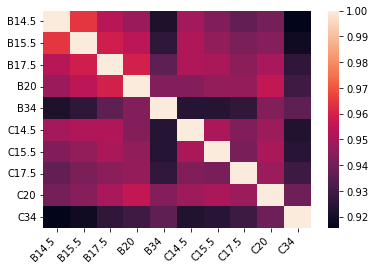

In [41]:
import seaborn as sns
corr = data.corr(method='spearman')
ax = sns.heatmap(corr)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')